In [1]:
#!/usr/bin/env python3
import os
from datetime import datetime
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

from src.architecture import SegmentationModel

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import array_to_img, load_img, save_img
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Conv2D, Conv2DTranspose, Cropping2D, Dropout, Input, MaxPool2D, Softmax, ZeroPadding2D, Flatten, Reshape
from tensorflow.keras.regularizers import l2

%matplotlib inline

### Build the model structure

Notes: https://stackoverflow.com/questions/47787011/how-to-disable-dropout-while-prediction-in-keras

In [2]:
input_shape = (375, 1242, 3)

In [3]:
inputs = Input(shape=input_shape, name='inputs')

In [4]:
conv1_1 = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv1_1')(inputs)

In [5]:
conv1_2 = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv1_2')(conv1_1)

In [6]:
pool1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1')(conv1_2)

In [7]:
conv2_1 = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv2_1')(pool1)

In [8]:
conv2_2 = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv2_2')(conv2_1)

In [9]:
pool2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2')(conv2_2)

In [10]:
conv3_1 = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv3_1')(pool2)

In [11]:
conv3_2 = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv3_2')(conv3_1)

In [12]:
conv3_3 = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv3_3')(conv3_2)

In [13]:
pool3 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3')(conv3_3)

In [14]:
conv4_1 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv4_1')(pool3)

In [15]:
conv4_2 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv4_2')(conv4_1)

In [16]:
conv4_3 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv4_3')(conv4_2)

In [17]:
pool4 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4')(conv4_3)

In [18]:
conv5_1 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv5_1')(pool4)

In [19]:
conv5_2 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv5_2')(conv5_1)

In [20]:
conv5_3 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', activation='relu', name='conv5_3')(conv5_2)

In [21]:
pool5 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool5')(conv5_3)

In [22]:
fc6 = Conv2D(filters=4096, kernel_size=(7, 7), strides=(1, 1), padding='same', activation='relu', name='fc6')(pool5)

In [23]:
fc6 = Dropout(rate=0.5, name='dropout_fc6')(fc6)

In [24]:
fc7 = Conv2D(filters=4096, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name='fc7')(fc6)

In [25]:
fc7 = Dropout(rate=0.5, name='dropout_fc7')(fc7)

In [26]:
score = Conv2D(filters=2, kernel_size=(1, 1), strides=(1, 1), kernel_regularizer=l2(l=(2/4096)**0.5), name='score')(fc7)

In [27]:
upscore2 = Conv2DTranspose(filters=2, kernel_size=(4, 4), strides=(2, 2), padding='same', name='upscore2')(score)

In [28]:
score_pool4 = Conv2D(filters=2, kernel_size=(1, 1), strides=(1, 1), kernel_regularizer=l2(l=0.001), name='score_pool4')(pool4)

In [29]:
shape_diff = upscore2.get_shape()[1] - score_pool4.get_shape()[1]
score_pool4 = ZeroPadding2D(padding=((0, shape_diff), (0, 0)))(score_pool4)

In [30]:
fuse_pool4 = Add(name='fuse_pool4')([upscore2, score_pool4])

In [31]:
upscore4 = Conv2DTranspose(filters=2, kernel_size=(4, 4), strides=(2, 2), padding='same', name='upscore4')(fuse_pool4)

In [32]:
score_pool3 = Conv2D(filters=2, kernel_size=(1, 1), strides=(1, 1),  padding='same', kernel_regularizer=l2(l=0.0001), name='score_pool3')(pool3)

In [33]:
shape_diff = upscore4.get_shape()[1] - score_pool3.get_shape()[1]
score_pool3 = ZeroPadding2D(padding=((0, shape_diff), (0, 0)))(score_pool3)

In [34]:
fuse_pool3 = Add(name='fuse_pool3')([upscore4, score_pool3])

In [35]:
upscore32 = Conv2DTranspose(filters=2, kernel_size=(16, 16), strides=(8, 8), padding='same', name='upscore32')(fuse_pool3)

In [36]:
row_shape_diff = upscore32.get_shape()[1] - inputs.get_shape()[1]
column_shape_diff = upscore32.get_shape()[2] - inputs.get_shape()[2]
upscore32 = Cropping2D(cropping=((0, row_shape_diff), (0, column_shape_diff)))(upscore32)

In [37]:
final_conv = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='sigmoid', name='final_conv')(upscore32)

In [38]:
#softmax = Softmax(name='softmax')(final_conv)

In [39]:
fm_model = Model(inputs=inputs, outputs=final_conv)

In [40]:
fm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 375, 1242, 3 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 375, 1242, 64 1792        inputs[0][0]                     
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 375, 1242, 64 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 188, 621, 64) 0           conv1_2[0][0]                    
______________________________________________________________________________________________

### Load VGG16 model weights up to conv5_3

In [41]:
keras_vgg16 = VGG16()

In [42]:
def load_vgg16_weights(fm_model):
    MAX_POOL1 = 3
    MAX_POOL2 = 6
    MAX_POOL3 = 10
    MAX_POOL4 = 14
    max_pool_indices = [MAX_POOL1, MAX_POOL2, MAX_POOL3, MAX_POOL4]
    
    for i in range(1, 17):
        if i in max_pool_indices:
            continue
        else:
            weights = keras_vgg16.get_layer(index=i).get_weights()
            fm_model.get_layer(index=i).set_weights(weights)

In [43]:
load_vgg16_weights(fm_model)

# Prepare the model for training

Before training with the Kitti road dataset, it was further processed. In particular the masks were cleaned from a third shade so that two colors remain, representing street and no-street areas. Also the folder structure was changed: The training folder consists of the folders `training_frames`, `training_masks`, `validation_frames` and `validation_masks`.

The images are splitted in ~80% (231 images) training data and ~20% (58 images) validation data.

In [44]:
LEARNING_RATE = 1e-05
EPSILON = 1e-05

In [45]:
#fm_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON), loss=CategoricalCrossentropy(from_logits=True), metrics=[MeanIoU(num_classes=2)])
fm_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON), loss=BinaryCrossentropy(from_logits=True), metrics=[MeanIoU(num_classes=2)])

# Prepare the training data

In [46]:
def map_to_masks(frame_directory):
    frame = tf.io.read_file(frame_directory)
    frame = tf.image.decode_png(frame, channels=3)
    frame = tf.image.convert_image_dtype(frame, tf.uint8)

    mask_directory = tf.strings.regex_replace(input=frame_directory, pattern='frames', rewrite=('masks'))
    
    mask = tf.io.read_file(mask_directory)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.uint8)
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    
    return {'frame': frame, 'mask': mask}

In [47]:
#training_directory = 'kitti_road_data/training/'
training_directory = 'test_data/training/'

In [48]:
training_frames_directory = training_directory + 'training_frames'
training_frames_directory = pathlib.Path(training_frames_directory)
training_frames = tf.data.Dataset.list_files(str(training_frames_directory/'u*'))
training_data = training_frames.map(map_to_masks)

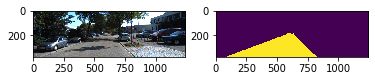

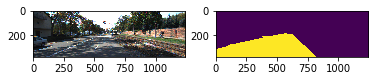

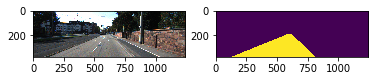

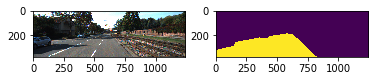

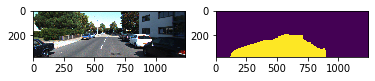

In [49]:
for index, image in enumerate(training_data.take(5)):
    plt.subplot(1, 2, 1)
    plt.imshow(array_to_img(image['frame']))
    plt.subplot(1, 2, 2)
    plt.imshow(array_to_img(image['mask']))
    plt.show()

In [50]:
validation_frames_directory = training_directory + 'validation_frames'
validation_frames_directory = pathlib.Path(validation_frames_directory)
validation_frames = tf.data.Dataset.list_files(str(validation_frames_directory/'u*'))
validation_data = validation_frames.map(map_to_masks)

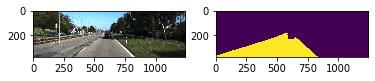

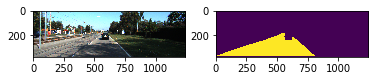

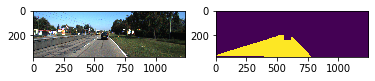

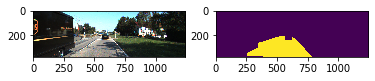

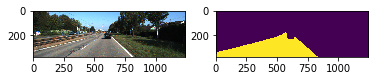

In [51]:
for index, image in enumerate(validation_data.take(5)):
    plt.subplot(1, 2, 1)
    plt.imshow(array_to_img(image['frame']))
    plt.subplot(1, 2, 2)
    plt.imshow(array_to_img(image['mask']))
    plt.show()

In [57]:
data_set = {'train': training_data, 'test': validation_data}

## Apply some data augmentation to the training data

The following functions are taken from: https://www.tensorflow.org/tutorials/images/segmentation<br>

In [52]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = (tf.cast(input_mask, tf.float32) - tf.math.reduce_min(input_mask)) / (tf.math.reduce_max(input_mask) - tf.math.reduce_min(input_mask))
    return input_image, input_mask

In [53]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['frame'], (375, 1242))
    input_mask = tf.image.resize(datapoint['mask'], (375, 1242))

    if (tf.random.uniform(()) > 0.5):
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [54]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['frame'], (375, 1242))
    input_mask = tf.image.resize(datapoint['mask'], (375, 1242))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Training Hyperparameters

In [55]:
TRAIN_LENGTH = len(list(training_frames_directory.glob('**/*.png')))
BATCH_SIZE = 1
EPOCHS = 1
VALIDATION_STEPS = 1
SAVE_CHECKPOINT_STEPS = TRAIN_LENGTH * 2
SHOW_IMAGE = 150

BUFFER_SIZE = TRAIN_LENGTH + 1

# Prepare the data further

In [58]:
train = data_set['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = data_set['test'].map(load_image_test)

In [59]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE).repeat()

In [60]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

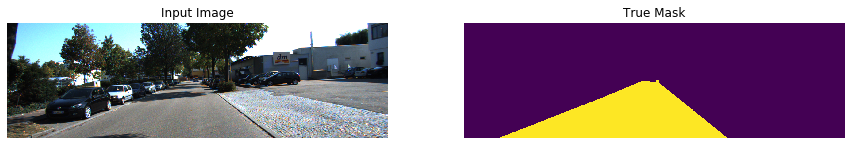

In [61]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [62]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [63]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(fm_model.predict(sample_image[tf.newaxis, ...]))])


In [64]:
class DisplayCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch % SHOW_IMAGE == 0):
            clear_output(wait=True)
            show_predictions()
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

## Define callbacks

In [65]:
log_dir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir)

In [66]:
checkpoint_dir = os.path.dirname("fm_model_checkpoints/cp.ckpt")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_dir, verbose=1, save_freq=SAVE_CHECKPOINT_STEPS)

## Train the model and save intermediate results and the final version

In [ ]:
model_history = fm_model.fit(train_dataset,
                             epochs=EPOCHS,
                             steps_per_epoch=TRAIN_LENGTH,
                             validation_steps=VALIDATION_STEPS,
                             validation_data=test_dataset,
                             callbacks=[DisplayCallback(), checkpoint_callback, tensorboard_callback])

In [191]:
fm_model.save(filepath='fm_model.h5')
fm_model.save_weights(filepath='fm_model_weights')

## Test the model

In [192]:
test_image = np.array(tf.keras.preprocessing.image.load_img('test_data/training/training_frames/um_000000.png'))

In [193]:
test_image = tf.cast(test_image, tf.float32) / 255.0

In [194]:
test_output = fm_model.predict(x=tf.expand_dims(test_image, 0))

In [197]:
squeezed_test_output = np.squeeze(test_output)

In [ ]:
plt.imshow(squeezed_test_output)
plt.show()